### Load data

In [1]:
!pip3 install pykan==0.2.2 kaleido

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 1.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 18.4 MB/s eta 0:00:0000:01m00:01


In [1]:
import plotly.io as pio

png_renderer = pio.renderers["png"]
png_renderer.width = 1500
png_renderer.height = 700
pio.renderers.default = "png"
pio.templates.default = "plotly_white"

In [2]:
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, InputLayer
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import CategoricalAccuracy, Precision, Recall
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve
from scipy.stats import ks_2samp
from tensorflow.keras.utils import to_categorical
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
import torch
from kan import KAN
import matplotlib.pyplot as plt
import numpy as np
from kan import KAN

df_train = pd.read_csv("/kaggle/input/kaaweq/train_processed_.csv")
df_val = pd.read_csv("/kaggle/input/kaaweq/val_processed.csv")
df_test = pd.read_csv("/kaggle/input/kaaweq/test_processed.csv")

2024-07-30 17:17:08.663608: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-30 17:17:08.663740: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-30 17:17:08.964807: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
torch.cuda.is_available()

True

In [4]:
df_train.head()

Age  Flight Distance  Inflight wifi service  \
0  0.205128         0.085622                    0.4   
1  0.371795         0.104806                    0.6   
2  0.358974         0.338853                    0.8   
3  0.551282         0.343700                    0.4   
4  0.179487         0.142165                    0.2   

   Departure/Arrival time convenient  Ease of Online booking  Gate location  \
0                                0.8                     1.0            0.6   
1                                0.4                     0.4            0.4   
2                                0.6                     0.8            0.4   
3                                0.6                     0.6            0.2   
4                                0.8                     0.2            0.2   

   Food and drink  Online boarding  Seat comfort  Inflight entertainment  ...  \
0             0.4              1.0           0.2                     0.4  ...   
1             0.4              0.4           0.4                     0.4  ...   
2             0.2              0.8           0.2                     0.2  ...   
3             0.6              0.4           0.6                     0.6  ...   
4             0.4              0.2           0.4                     0.4  ...   

   not_satisfied_client  Gender_Female  Gender_Male  \
0                   1.0            1.0          0.0   
1                   1.0            1.0          0.0   
2                   1.0            0.0          1.0   
3                   1.0            1.0          0.0   
4                   1.0            0.0          1.0   

   Customer Type_Loyal Customer  Customer Type_disloyal Customer  \
0                           1.0                              0.0   
1                           0.0                              1.0   
2                           1.0                              0.0   
3                           0.0                              1.0   
4                           1.0                              0.0   

   Type of Travel_Business travel  Type of Travel_Personal Travel  \
0                             0.0                             1.0   
1                             1.0                             0.0   
2                             0.0                             1.0   
3                             1.0                             0.0   
4                             0.0                             1.0   

   Class_Business  Class_Eco  Class_Eco Plus  
0             0.0        1.0             0.0  
1             1.0        0.0             0.0  
2             0.0        1.0             0.0  
3             1.0        0.0             0.0  
4             0.0        1.0             0.0  

[5 rows x 28 columns]

In [5]:
X_train = df_train.drop('not_satisfied_client', axis=1)
y_train = df_train['not_satisfied_client'].astype("int")

X_val = df_val.drop('not_satisfied_client', axis=1)
y_val = df_val['not_satisfied_client'].astype("int")

X_test = df_test.drop('not_satisfied_client', axis=1)
y_test = df_test['not_satisfied_client'].astype("int")

In [6]:
from kan import KAN
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import torch
import numpy as np



In [131]:
train_input = torch.tensor(X_train.values, dtype=torch.float32)
train_label = torch.tensor(y_train.values, dtype=torch.long)
test_input = torch.tensor(X_test.values, dtype=torch.float32)
test_label = torch.tensor(y_test.values, dtype=torch.long)
val_input = torch.tensor(X_val.values, dtype=torch.float32)
val_label = torch.tensor(y_val.values, dtype=torch.long)

dataset = {
    'train_input': train_input,
    'train_label': train_label,
    'test_input': test_input,
    'test_label': test_label,
    'val_input': val_input,
    'val_label': val_label
}

### Experiments

In [132]:
import torch.nn as nn

def build_model(width, steps, grid, k):
    model = KAN(width=width, grid=grid, k=k)

    return model

In [133]:
def evaluate_model(y_test, y_pred):
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Calculate precision, recall, and f1-score
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    # Calculate AUROC
    auroc = roc_auc_score(y_test, y_pred, multi_class='ovr')

    # Calculate Kolmogorov-Smirnov (KS) test
    group_0 = y_pred[y_test == 0]
    group_1 = y_pred[y_test == 1]

    # Perform the KS test
    ks_statistic, p_value = ks_2samp(group_0, group_1)

    return accuracy, precision, recall, f1, auroc, ks_statistic

In [134]:
results = []

best_ks_stat = -1
best_model = None

for idx, config in enumerate(experiments):
    model = build_model(**config)
    history = model.fit(dataset, steps=config['steps'], loss_fn=torch.nn.CrossEntropyLoss())
    y_pred = model(dataset['test_input'])
    accuracy, precision, recall, f1, auroc, ks_stat = evaluate_model(y_test.values, (torch.argmax(y_pred, dim=1)))
    results.append((idx + 1, config, accuracy, precision, recall, f1, auroc, ks_stat))

    if ks_stat > best_ks_stat:
        best_ks_stat = ks_stat
        best_model = model

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.20e-01 | test_loss: 4.23e-01 | reg: 7.21e+00 | : 100%|█| 20/20 [09:03<00:00, 27.16s/


saving model version 0.1


In [135]:
results_df = pd.DataFrame(results, columns=['Experiment', 'Config', 'Accuracy', 'Precision', 'Recall', 'F1', 'AUROC', 'KS'])
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

styled_df = results_df.style.apply(highlight_max, subset=['Accuracy', 'Precision', 'Recall', 'F1', 'AUROC', 'KS'])
styled_df

### Analysis pos-hoc

In [136]:
y_pred = best_model(dataset['test_input'])
y_pred = torch.softmax(y_pred, dim=1)[:, 1].detach().numpy()

In [137]:
# fixes much clients with same output

import numpy as np
y_pred += np.random.normal(scale=1e-5, size=len(y_pred))


In [138]:
from plotly.subplots import make_subplots
import numpy as np
import plotly.graph_objects as go
from sklearn.metrics import roc_curve

In [139]:
def plot_target_vs_score(target, scores, quantiles, lower_limit=None):
    eval_df = pd.DataFrame(zip(target, scores), columns=['TARGET', 'SCORE']).sort_values(by='SCORE')

    quantile = pd.qcut(eval_df['SCORE'], quantiles, labels=range(1,1+quantiles))
    eval_df['QUANTILE'] = quantile
    if lower_limit:
        eval_df = eval_df.loc[eval_df['QUANTILE'] > lower_limit]

    chart_df = pd.DataFrame(zip(
      eval_df.groupby('QUANTILE')['TARGET'].mean(), eval_df.groupby('QUANTILE')['TARGET'].size()/eval_df.shape[0]
      ), columns=['TAXA_DE_MAUS', 'POPULACAO'])

    fig = make_subplots(specs=[[{"secondary_y": True}]])

    chart_df = chart_df.dropna()
    # Add traces
    fig.add_trace(
      go.Bar(x=chart_df.index.to_list(), y=chart_df.POPULACAO, name="Representatividade (%)", marker_color='rgba(0, 0, 87, .8)'),
      secondary_y=False,
    )

    fig.add_trace(
      go.Scatter(x=chart_df.index.to_list(), y=chart_df.TAXA_DE_MAUS, name="Média do alvo ponderada pela exposição (%)", marker_color='red'),
      secondary_y=True,
      #labels=dict(x="Decil", y="Representatividade (%)")
    )

    fig.update_xaxes(title_text='Decil da população')
    fig.update_yaxes(title_text='Representatividade (%)', secondary_y=False)
    fig.update_yaxes(title_text='Média do alvo ponderada pela exposição (%)', secondary_y=True)
    fig.update_layout(
      width=1000,height=500,
      legend=dict(orientation="h", xanchor='center', x=0.5, y=-0.2))

    fig.show()

In [140]:
plot_target_vs_score(y_test, y_pred, 10)

/tmp/ipykernel_34/1750370197.py:10: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [141]:
import numpy as np
import plotly.graph_objects as go
from sklearn.metrics import roc_curve

def binary_ks_curve(y_true, y_probas):
    # Sort probabilities and true values
    sorted_indices = np.argsort(y_probas)
    sorted_probas = y_probas[sorted_indices]
    sorted_true = y_true[sorted_indices]

    # Compute the cumulative percentage of positives and negatives
    cum_pos = np.cumsum(sorted_true) / np.sum(sorted_true)
    cum_neg = np.cumsum(1 - sorted_true) / np.sum(1 - sorted_true)

    thresholds = np.concatenate([[0], sorted_probas, [1]])
    pct1 = np.concatenate([[0], cum_pos, [1]])
    pct2 = np.concatenate([[0], cum_neg, [1]])

    ks_statistic = np.max(np.abs(pct1 - pct2))
    max_distance_at = thresholds[np.argmax(np.abs(pct1 - pct2))]

    return thresholds, pct1, pct2, ks_statistic, max_distance_at, [0, 1]

def plot_ks_curve(y_true, y_probas, title='KS Curve', title_fontsize=14, text_fontsize=12):
    y_true = np.array(y_true)
    y_probas = np.array(y_probas)

    classes = np.unique(y_true)
    if len(classes) != 2:
        raise ValueError('Cannot calculate KS statistic for data with '
                         '{} category/ies'.format(len(classes)))
    probas = y_probas

    # Compute KS Statistic curves
    thresholds, pct1, pct2, ks_statistic, max_distance_at, classes = binary_ks_curve(y_true, probas.ravel())

    # Create the plotly figure
    fig = go.Figure()

    # Add the percentage below threshold for each class
    fig.add_trace(go.Scatter(x=thresholds, y=pct1, mode='lines', name=f'Class {classes[0]}', line=dict(width=3)))
    fig.add_trace(go.Scatter(x=thresholds, y=pct2, mode='lines', name=f'Class {classes[1]}', line=dict(width=3)))

    # Add the KS Statistic line
    idx = np.where(thresholds == max_distance_at)[0][0]
    fig.add_vline(x=max_distance_at, line_width=3, line_dash='dash', line_color='black',
                  annotation_text=f'KS Statistic: {ks_statistic:.3f} at {max_distance_at:.3f}',
                  annotation_position='top', annotation_font_size=text_fontsize)

    # Update layout
    fig.update_layout(
        title=title, title_font_size=title_fontsize,
        xaxis_title='Threshold', xaxis_title_font_size=text_fontsize,
        yaxis_title='Percentage below threshold', yaxis_title_font_size=text_fontsize,
        xaxis=dict(range=[0.0, 1.0]),
        yaxis=dict(range=[0.0, 1.0]),
        legend=dict(x=0.75, y=0.1, font_size=text_fontsize),
        font=dict(size=text_fontsize)
    )

    return fig

fig = plot_ks_curve(list(y_test), list(y_pred), title='KS Curve')
fig.show()

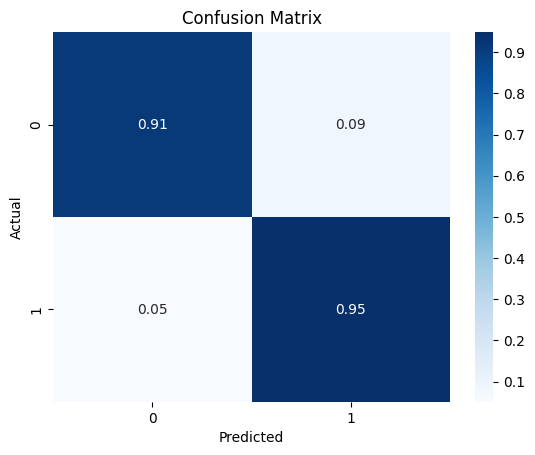

In [24]:
# prompt: plot confusion matrix

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get confusion matrix
cm = confusion_matrix(y_test, (y_pred > 0.5).astype(int))
cm_normalized = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

# Create heatmap
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues")

# Set labels and title
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

# Show plot
plt.show()


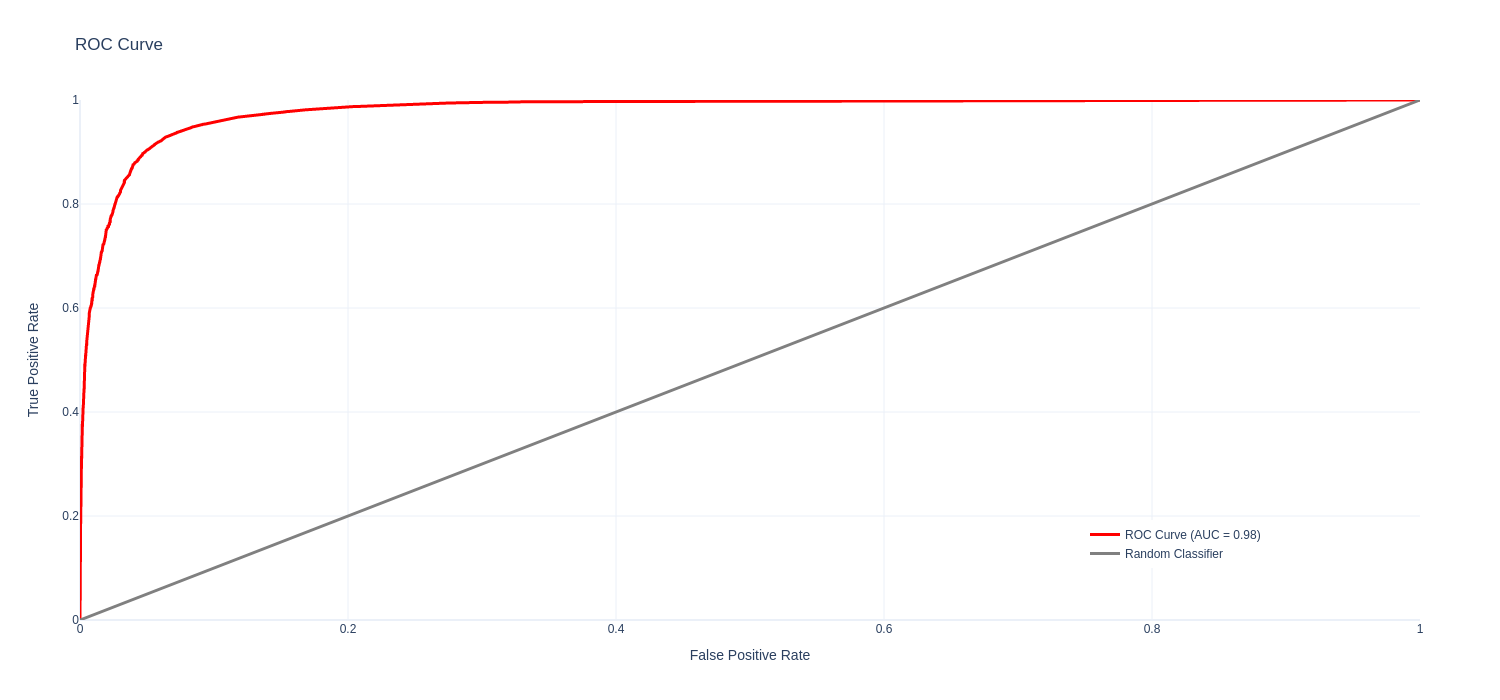

In [25]:
from sklearn.metrics import roc_curve, auc

# Calculate ROC and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Create plotly figure
fig = go.Figure()

# Add ROC curve trace
fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name=f"ROC Curve (AUC = {roc_auc:.2f})", line=dict(color='red', width=3)))

# Add diagonal line
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Random Classifier', line=dict(color='grey', width=3)))

# Add annotations

# Update layout
fig.update_layout(
    title='ROC Curve',
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    xaxis=dict(range=[0.0, 1.0]),
    yaxis=dict(range=[0.0, 1.0]),
    legend=dict(x=0.75, y=0.1),
    font=dict(size=12),
    width=600,
    height=600
)

# Show plot
fig.show()


In [31]:
from kan.utils import ex_round


In [64]:
import matplotlib

matplotlib.rcParams['figure.figsize'] = (10, 10)


In [72]:
pd.DataFrame(zip(range(len(X_train.columns)), X_train.columns.tolist()))

0                                  1
0    0                                Age
1    1                    Flight Distance
2    2              Inflight wifi service
3    3  Departure/Arrival time convenient
4    4             Ease of Online booking
5    5                      Gate location
6    6                     Food and drink
7    7                    Online boarding
8    8                       Seat comfort
9    9             Inflight entertainment
10  10                   On-board service
11  11                   Leg room service
12  12                   Baggage handling
13  13                    Checkin service
14  14                   Inflight service
15  15                        Cleanliness
16  16         Departure Delay in Minutes
17  17           Arrival Delay in Minutes
18  18                      Gender_Female
19  19                        Gender_Male
20  20       Customer Type_Loyal Customer
21  21    Customer Type_disloyal Customer
22  22     Type of Travel_Business travel
23  23     Type of Travel_Personal Travel
24  24                     Class_Business
25  25                          Class_Eco
26  26                     Class_Eco Plus

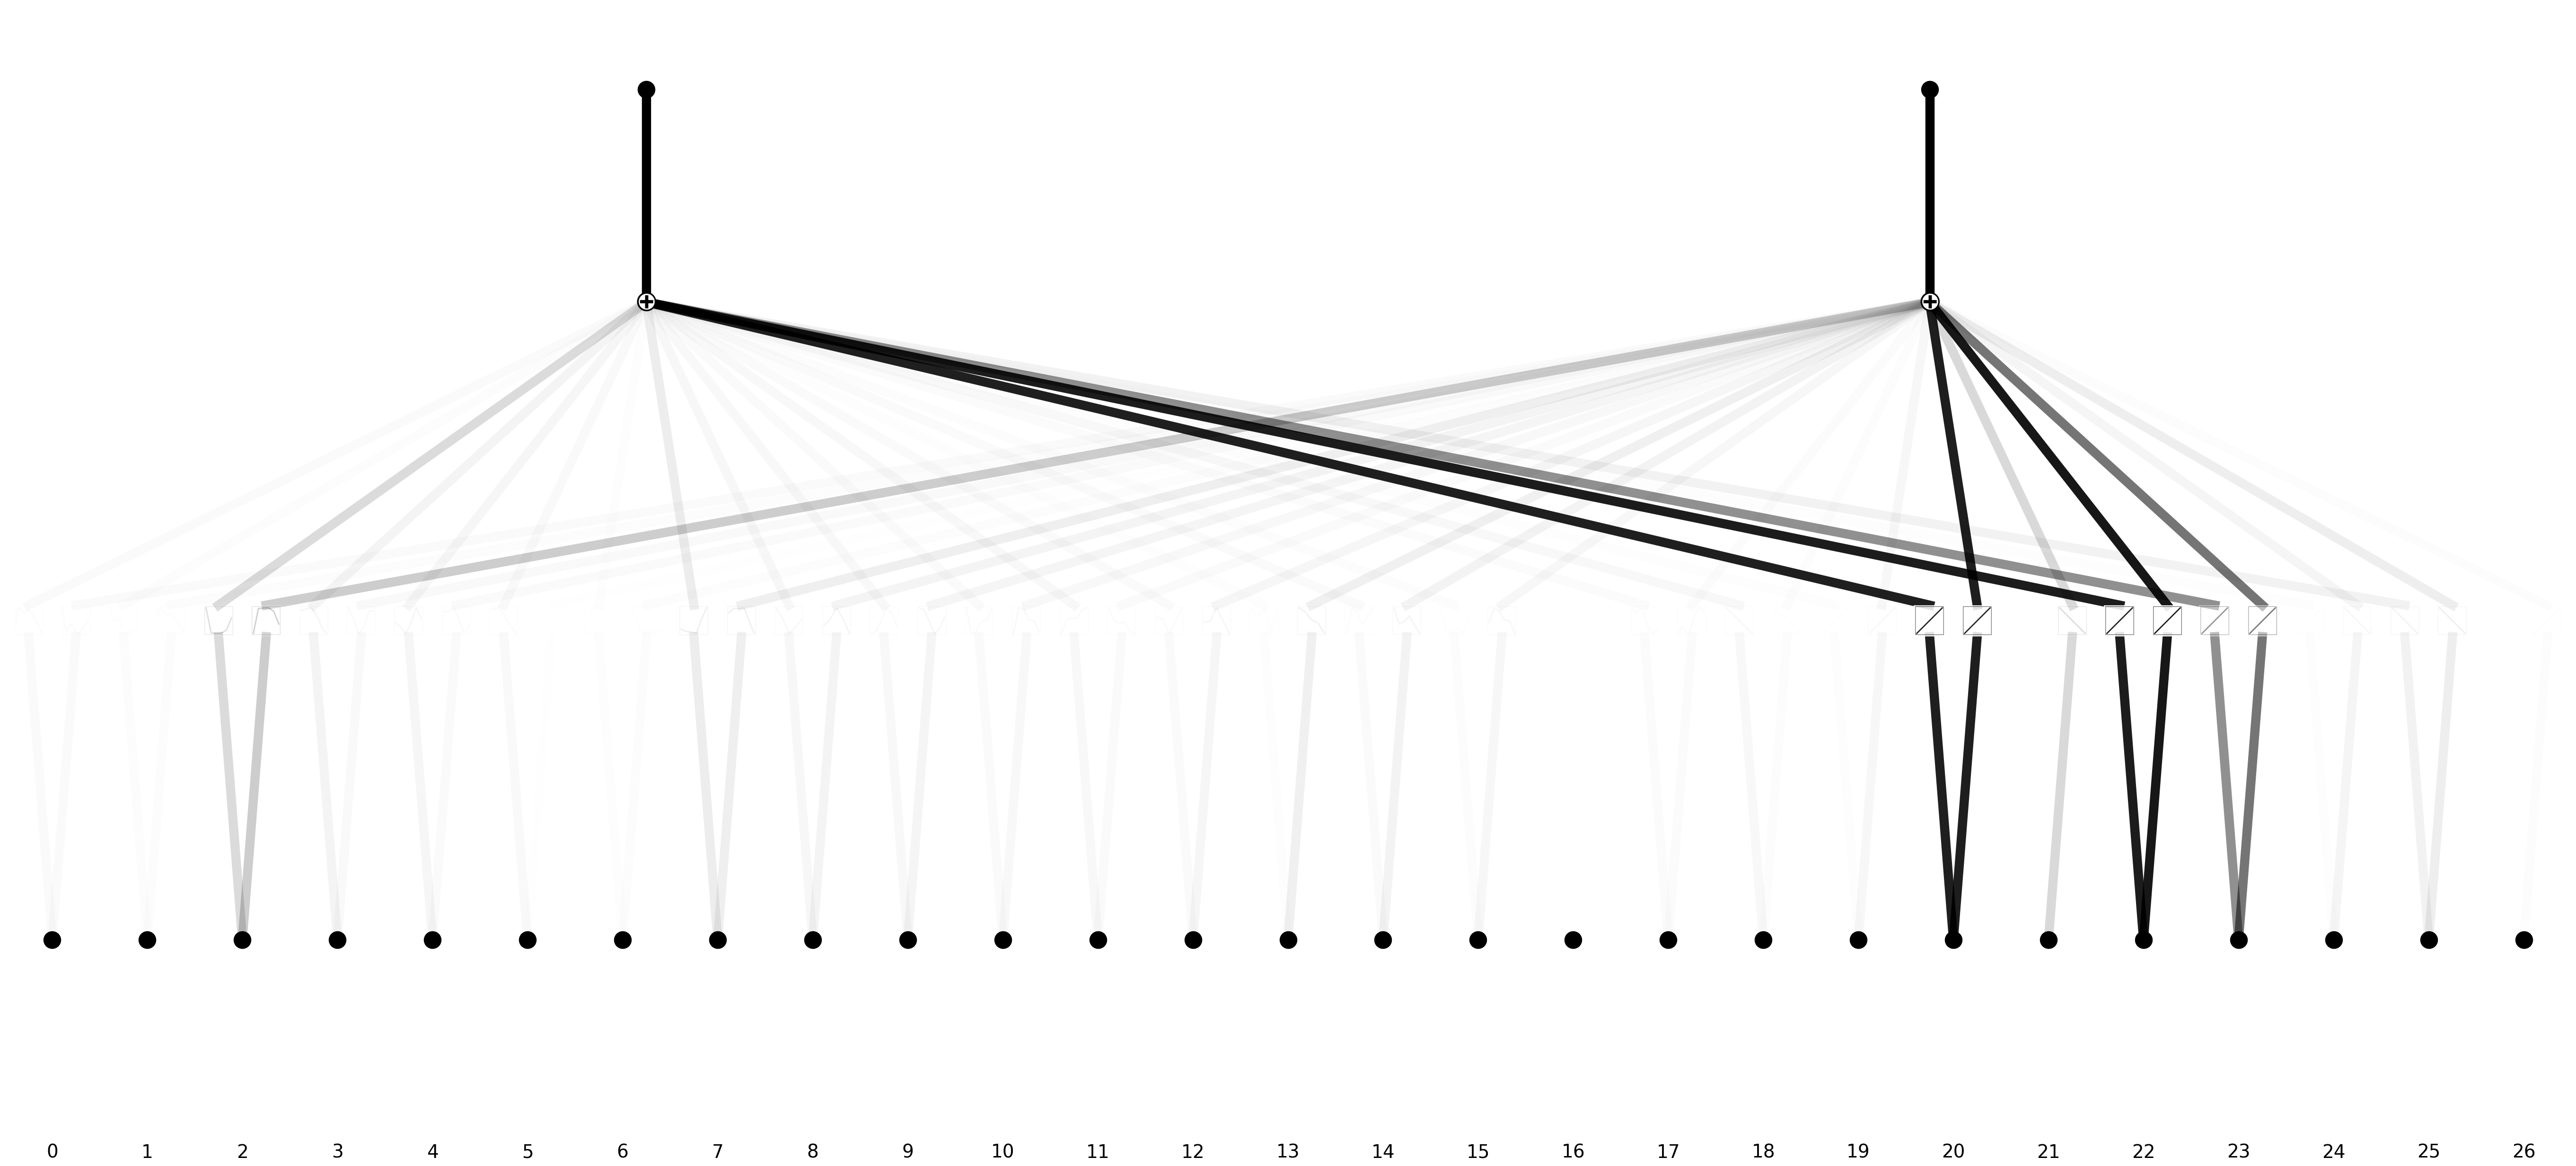

In [13]:
best_model.plot(scale=7,in_vars=list(range(len(X_train.columns))), varscale=0.1)


saving model version 0.2


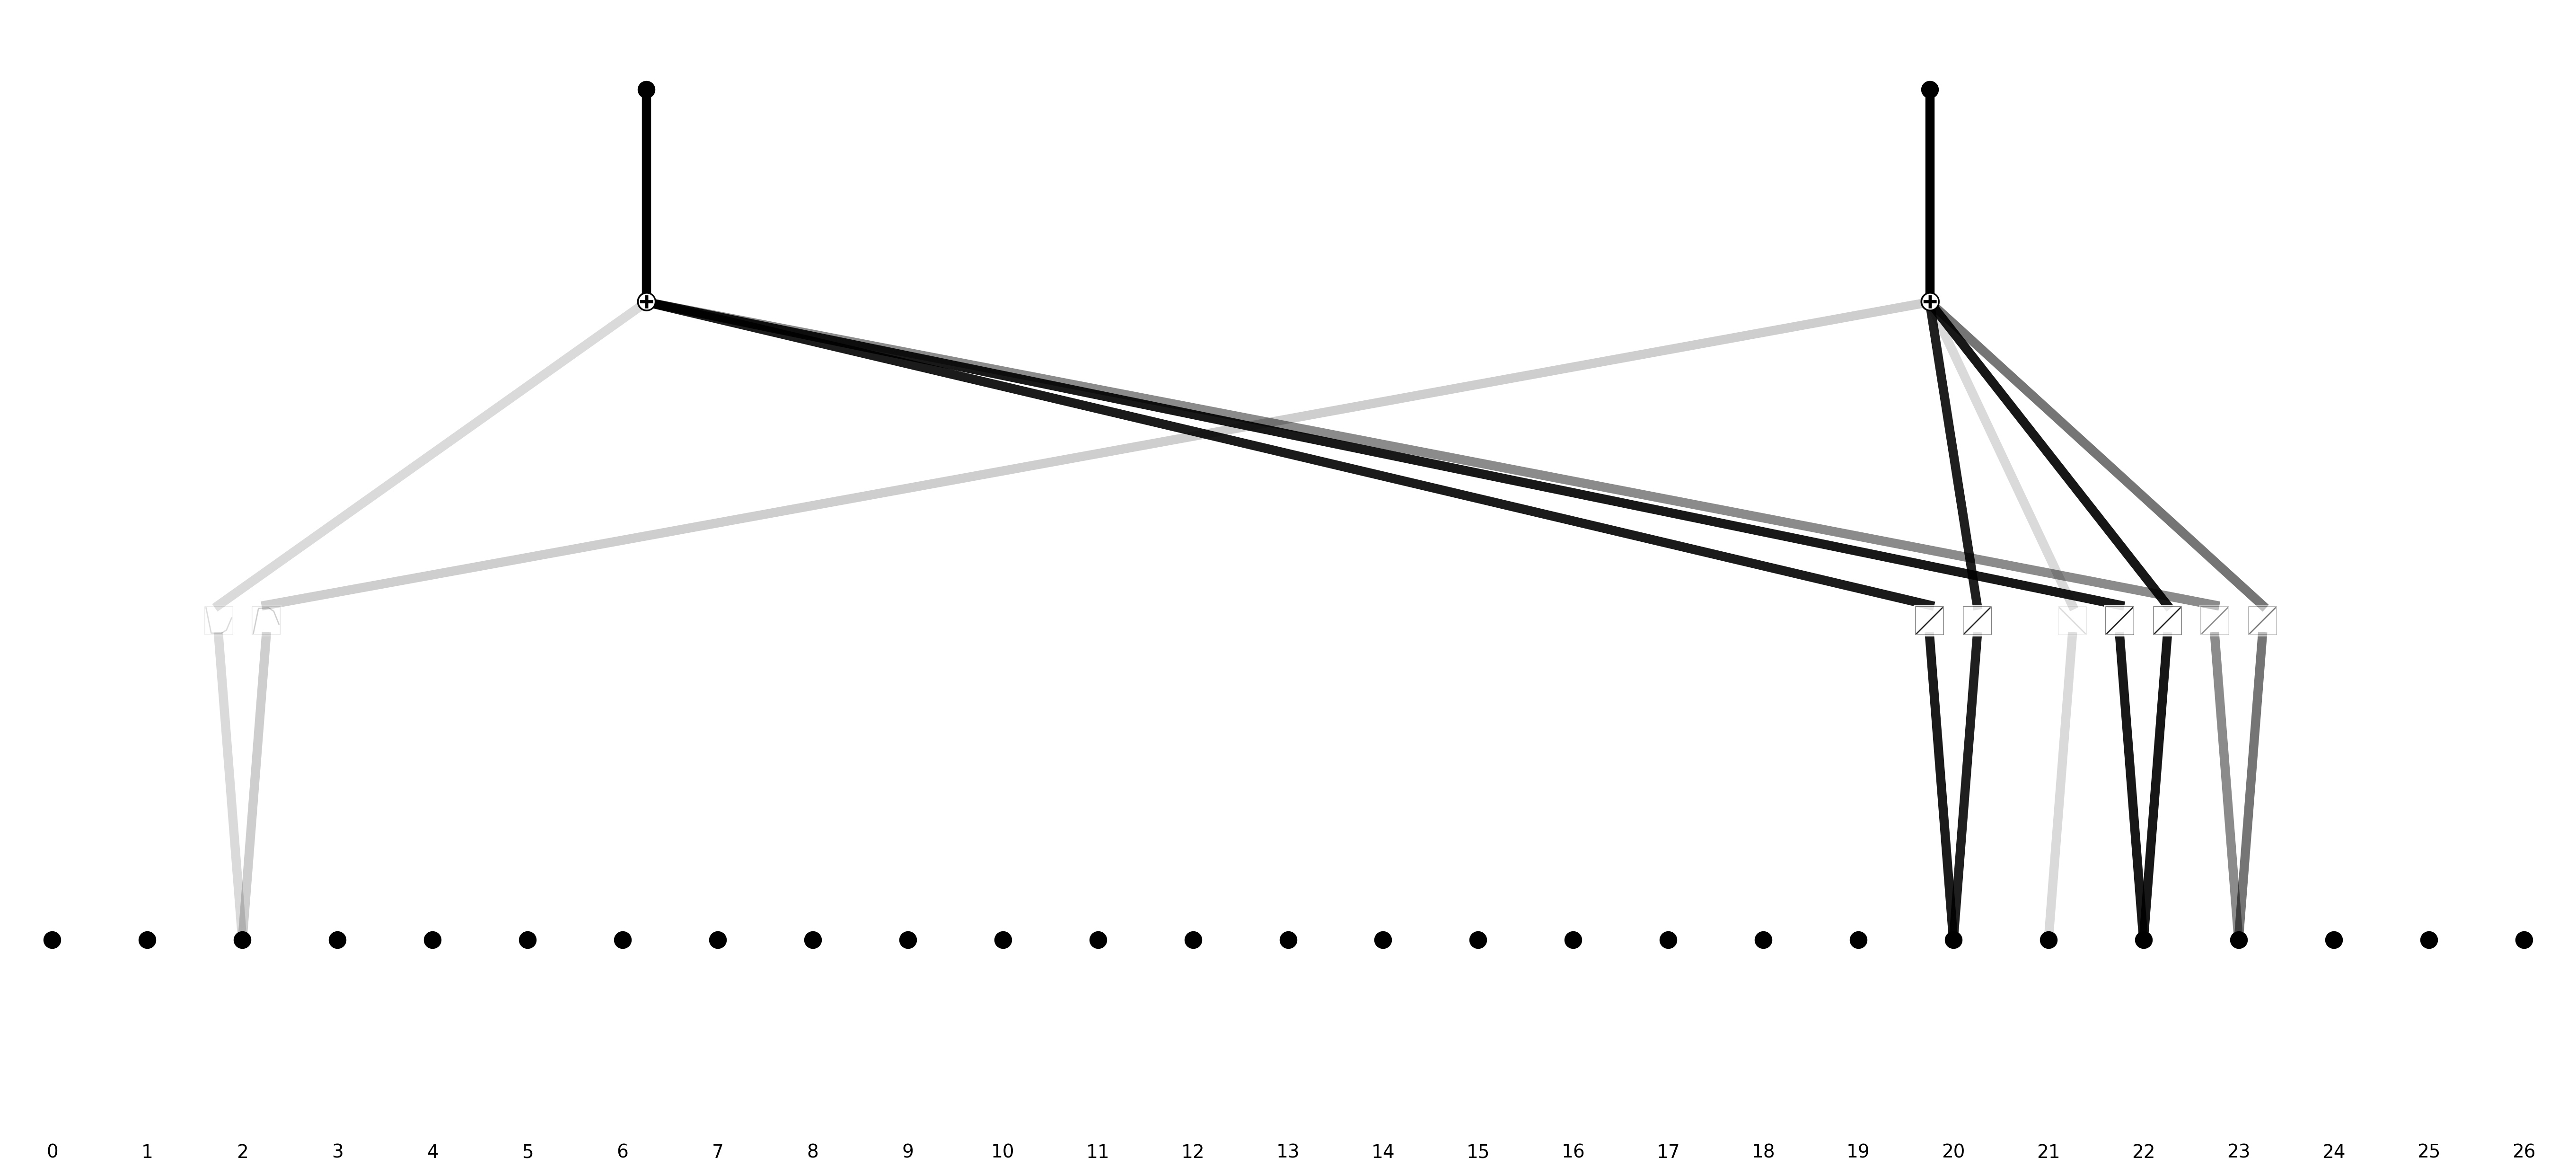

In [14]:
best_model = best_model.prune()
best_model(dataset['train_input'])
best_model.plot(scale=7,in_vars=list(range(len(X_train.columns))), varscale=0.1)

In [15]:
lib = ['x','x^2']
best_model.auto_symbolic(lib=lib)
formula = best_model.symbolic_formula()[0][0]
formula

fixing (0,0,0) with 0
fixing (0,0,1) with 0
fixing (0,1,0) with 0
fixing (0,1,1) with 0
fixing (0,2,0) with x, r2=0.09088467806577682, c=1
fixing (0,2,1) with x, r2=0.09598188102245331, c=1
fixing (0,3,0) with 0
fixing (0,3,1) with 0
fixing (0,4,0) with 0
fixing (0,4,1) with 0
fixing (0,5,0) with 0
fixing (0,5,1) with 0
fixing (0,6,0) with 0
fixing (0,6,1) with 0
fixing (0,7,0) with 0
fixing (0,7,1) with 0
fixing (0,8,0) with 0
fixing (0,8,1) with 0
fixing (0,9,0) with 0
fixing (0,9,1) with 0
fixing (0,10,0) with 0
fixing (0,10,1) with 0
fixing (0,11,0) with 0
fixing (0,11,1) with 0
fixing (0,12,0) with 0
fixing (0,12,1) with 0
fixing (0,13,0) with 0
fixing (0,13,1) with 0
fixing (0,14,0) with 0
fixing (0,14,1) with 0
fixing (0,15,0) with 0
fixing (0,15,1) with 0
fixing (0,16,0) with 0
fixing (0,16,1) with 0
fixing (0,17,0) with 0
fixing (0,17,1) with 0
fixing (0,18,0) with 0
fixing (0,18,1) with 0
fixing (0,19,0) with 0
fixing (0,19,1) with 0
fixing (0,20,0) with x, r2=1.0000008344650

32.9801195138086*x_21 + 28.786863224057*x_23 + 9.40322769613198*x_24 + 1.46697096116355*x_3 - 45.6800868240596

In [20]:
from sympy import *

In [77]:
input_variables = symbols(' '.join([F"X_{str(x).replace(' ', '')}" for x in list(range(len((X_train.columns))))]))
formula1, formula2 = best_model.symbolic_formula(var=input_variables)[0]
formula1 # Formula logit 1

1.46697096116355*X_2 + 32.9801195138086*X_20 + 28.786863224057*X_22 + 9.40322769613198*X_23 - 45.6800868240596

In [78]:
formula2 # Formula logit 2

-1.7342461258194*X_2 + 26.7900980784023*X_20 - 2.8750772985523*X_21 + 25.1219569173559*X_22 + 9.93664935002744*X_23 - 33.1331630079082

In [81]:
len(X_test)

25976

In [82]:
y_pred = []
for n in range(X_test.shape[0]):
    expression1 = formula1
    expression2 = formula2
    for i, column in enumerate(maps):
        expression1 = expression1.subs(column, X_test.values[n, i])
        expression2 = expression2.subs(column, X_test.values[n, i])

    logit1 = np.array(expression1).astype(np.float64)
    logit2 = np.array(expression2).astype(np.float64)

    y_pred.append([logit1, logit2])

In [122]:
def softmax(x):
    e_x = np.exp(x - np.max(x))  # Subtract max for numerical stability
    return e_x / e_x.sum(axis=1, keepdims=True)

# Get probability scores
probabilities = softmax(y_pred)
print(probabilities)

[[0.62462384 0.37537616]
 [0.1138754  0.8861246 ]
 [0.00878006 0.99121994]
 ...
 [0.00364831 0.99635169]
 [0.31620535 0.68379465]
 [0.00364831 0.99635169]]


In [124]:
probabilities

array([[0.62462384, 0.37537616],
       [0.1138754 , 0.8861246 ],
       [0.00878006, 0.99121994],
       ...,
       [0.00364831, 0.99635169],
       [0.31620535, 0.68379465],
       [0.00364831, 0.99635169]])

In [127]:
predictions = probabilities[:, 1]

In [128]:
predictions += np.random.normal(scale=1e-5, size=len(predictions))
plot_target_vs_score(y_test, predictions, 10)

/tmp/ipykernel_34/1750370197.py:10: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [129]:
fig = plot_ks_curve(list(y_test), list(predictions), title='KS Curve')
fig.show()